<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%; font-size:50px">Bees, Wasps or Other Insects</h1>
<hr>
<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Imports</h1>


In [2]:
import os
import PIL
import cv2
import math
import time
import random
import librosa
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, \
classification_report, log_loss ,precision_recall_curve, balanced_accuracy_score

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Constants and Global Variables</h1>


In [3]:
DATASET_PATH = '../Datasets/On Door/'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SAMPLE_RATE = 22050

In [4]:
models = {
    'buzzingDetection':layers.SimpleRNN, 
    'insectDetection': None, 
    'beeOrNot': None, 
    'waspOrNot': None, 
    'decisionMaking': None
    }
datasets = ['BuzzOrNot', 'BeeOrNot', 'WaspOrNot']

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Evaluation</h1>


In [5]:
def evaluateModel(yTrue, yPred, yProb=None):
    accuracy = accuracy_score(yTrue, yPred)
    print(f"Accuracy: {accuracy:.4f}")
    
    balancedAcc = balanced_accuracy_score(yTrue, yPred)
    print(f"Balanced Accuracy: {balancedAcc:.4f}")
    
    precision = precision_score(yTrue, yPred)
    print(f"Precision: {precision:.4f}")
    
    recall = recall_score(yTrue, yPred)
    print(f"Recall: {recall:.4f}")
    
    f1 = f1_score(yTrue, yPred)
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(yTrue, yPred)
    print(f"Confusion Matrix:\n{cm}")
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if yProb is not None:
        rocAuc = roc_auc_score(yTrue, yProb)
        print(f"ROC AUC Score: {rocAuc:.4f}")
        
        fpr, tpr, _ = roc_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {rocAuc:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        precisionCurve, recallCurve, _ = precision_recall_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(recallCurve, precisionCurve, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.show()

    if yProb is not None:
        logloss = log_loss(yTrue, yProb)
        print(f"Log Loss: {logloss:.4f}")

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Buzz Detection (Sound Classification)</h1>


---


<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Segmentation</h2>


In [6]:
def loadAudio(sub='/train'):
    print(f"\nLoading audio data from {DATASET_PATH + datasets[0] + sub}...")
    PATH = DATASET_PATH + datasets[0] + sub
    segments = []
    targets = []
    
    for filename in os.listdir(PATH):
        if filename.endswith('.wav'):
            audio = os.path.join(PATH, filename)
            label = filename.split('.')[0].split('_')[0]
            try:
                audio, sampleRate = librosa.load(audio)
                segments.append(audio)
                targets.append('Buzzing' if filename.startswith( 'Bee') else 'No Buzzing')
            except:
                os.remove(audio)
  
    return segments, np.array(targets)       

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Pre-Proccessing</h2>


In [7]:
def extractMFCC(segments, n_mfcc=12):
    print(f"\nPadded MFCC extraction for {len(segments)} segments...")
    mfccs = []
    mfccs = [librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE, n_mfcc=n_mfcc) for segment in segments]
    return mfccs, max([mfcc.shape[1] for mfcc in mfccs])


In [8]:
def pad(mfccs, maxLength):
    features = [
        np.pad(mfcc, ((0, 0), (0, maxLength - mfcc.shape[1])), mode='constant') 
        for mfcc in mfccs
    ]
    return np.array(features)

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio PipeLine</h2>


In [9]:
def audioPipeline():
    xTrain, yTrain = loadAudio('/train/')
    xTest, yTest = loadAudio('/test/')
    xTrain, maxTrainLength = extractMFCC(xTrain)
    xTest, maxTestLength = extractMFCC(xTest)
    xTrain = pad(xTrain, max(maxTrainLength, maxTestLength))
    xTest = pad(xTest, max(maxTrainLength, maxTestLength))
    yTrain = np.array([1 if label == 'Buzzing' else 0 for label in yTrain])
    yTest = np.array([1 if label == 'Buzzing' else 0 for label in yTest])
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Bee Detection (Image Classification)</h1>
<hr>
<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Loading Images</h2>


In [10]:
def loadImages(index, sub, positive):
    print(f"\nLoading image data from {DATASET_PATH + datasets[index] + sub}...")
    PATH = DATASET_PATH + datasets[index] + sub
    subDirs = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
    targets = []
    images = []
    
    for target in subDirs:
        targetPath = os.path.join(PATH, target)   
        
        for filename in os.listdir(targetPath):
            if filename.endswith(('.jpg', '.png')): 
                image = os.path.join(targetPath, filename)
                img = cv2.imread(image)
                img = cv2.resize(img, IMAGE_SIZE) 
                targets.append(target)
                images.append(img)
    targets = np.array([1 if target == positive else 0 for target in targets])            
    return np.array(images), np.array(targets)

In [11]:
def extractImages(index, positive):
    xTrain, yTrain = loadImages(index, '/train/', positive)
    xTest, yTest = loadImages(index, '/test/', positive)
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Model Building</h1>


In [12]:
def buildForBuzz(shape, modelType):  
        print(f"\nBuilding {modelType.__name__} with input shape {shape}...")
        model = Sequential()
        model.add(layers.Input(shape=shape))
        
        model.add(modelType(128, return_sequences=True))
        model.add(modelType(64))
        #model.add(layers.Dense(64, activation='tanh'))

        
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

In [13]:
def buildForInsects():
    model = Sequential()
    resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),pooling='avg')
    
    for layer in resnet.layers:
        layer.trainable=False
        
    model.add(resnet)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def train(model, xTrain, yTrain, xVal, yVal):
    print(f"\nTraining {model.layers[0].__class__.__name__} model...")
    model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)
    predictions = model.predict(xVal)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yVal, predictions)
    return model

In [15]:
def test(model, xTest, yTest):
    predictions = model.predict(xTest)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yTest, predictions)

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%; font-size:50px">Main</h1>



Loading audio data from ../Datasets/On Door/BuzzOrNot/train/...

Loading audio data from ../Datasets/On Door/BuzzOrNot/test/...

Padded MFCC extraction for 1983 segments...

Padded MFCC extraction for 852 segments...

Building LSTM with input shape (12, 432)...

Training LSTM model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7941 - loss: 0.4363 - val_accuracy: 0.9421 - val_loss: 0.1773
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9633 - loss: 0.1331 - val_accuracy: 0.9547 - val_loss: 0.1349
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9792 - loss: 0.0750 - val_accuracy: 0.9547 - val_loss: 0.1255
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9865 - loss: 0.0468 - val_accuracy: 0.9471 - val_loss: 0.1523
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9779 - loss: 0.0687 - val_accuracy: 0.9521 - val_loss: 0.1424
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9892 - loss: 

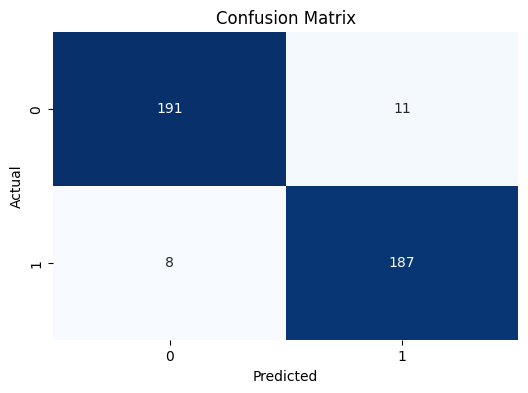

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.9484
Balanced Accuracy: 0.9484
Precision: 0.9526
Recall: 0.9437
F1 Score: 0.9481
Confusion Matrix:
[[406  20]
 [ 24 402]]


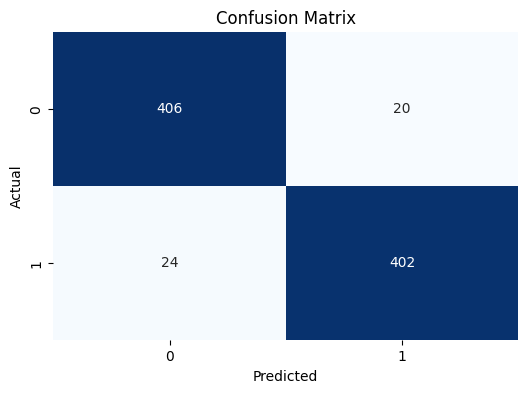


Building GRU with input shape (12, 432)...

Training GRU model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8049 - loss: 0.4269 - val_accuracy: 0.9370 - val_loss: 0.2068
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9536 - loss: 0.1499 - val_accuracy: 0.8992 - val_loss: 0.2340
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9738 - loss: 0.0869 - val_accuracy: 0.9471 - val_loss: 0.1799
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9936 - loss: 0.0324 - val_accuracy: 0.9320 - val_loss: 0.2034
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9925 - loss: 0.0299 - val_accuracy: 0.9169 - val_loss: 0.2341
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9974 - loss: 0.0128 - val_accuracy: 0.9421 - val_loss: 0.2134
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9947 - loss: 0.0172 - val_accuracy: 0.9345 - val_loss: 0.2350
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13m

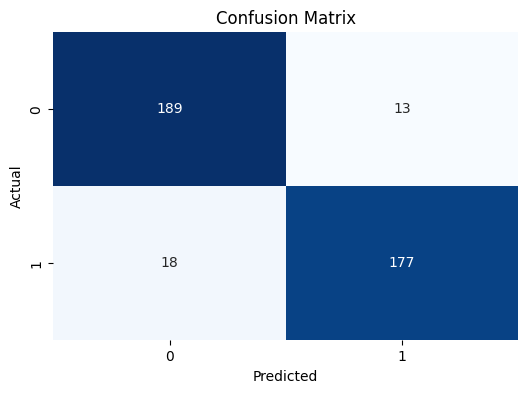

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8709
Balanced Accuracy: 0.8709
Precision: 0.8527
Recall: 0.8967
F1 Score: 0.8741
Confusion Matrix:
[[360  66]
 [ 44 382]]


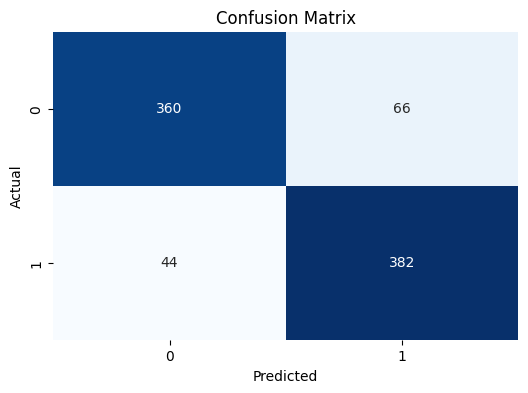


Building SimpleRNN with input shape (12, 432)...

Training SimpleRNN model...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7247 - loss: 0.5567 - val_accuracy: 0.9295 - val_loss: 0.2605
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9601 - loss: 0.1731 - val_accuracy: 0.9471 - val_loss: 0.1631
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9863 - loss: 0.0888 - val_accuracy: 0.9572 - val_loss: 0.1474
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0375 - val_accuracy: 0.9547 - val_loss: 0.1533
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0262 - val_accuracy: 0.9547 - val_loss: 0.1464
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0137 - val_accuracy: 0.9622 - val_loss: 0.1502
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0044 - val_accuracy: 0.9572 - val_loss: 0.1482
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 

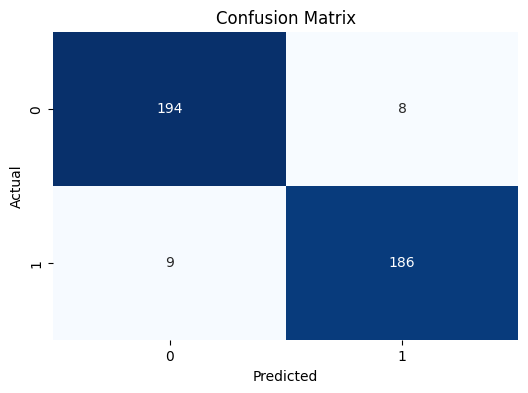

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9695
Balanced Accuracy: 0.9695
Precision: 0.9717
Recall: 0.9671
F1 Score: 0.9694
Confusion Matrix:
[[414  12]
 [ 14 412]]


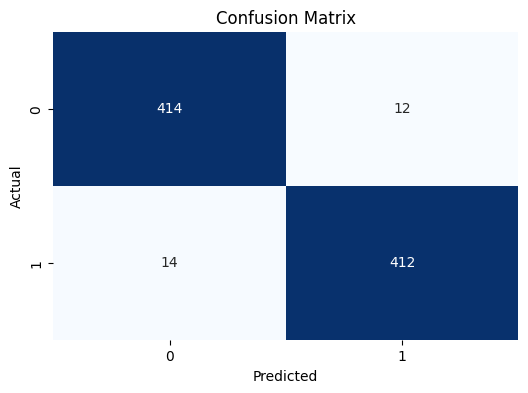

In [16]:
def compareAudioModels(): 
    xTrain, yTrain, xVal, yVal, xTest, yTest = audioPipeline()
    models = [layers.LSTM, layers.GRU, layers.SimpleRNN]
    bestModel = None
    
    for model in models:
        model = buildForBuzz(xTrain.shape[1:], model)
        model = train(model, xTrain, yTrain, xVal, yVal)
        test(model, xTest, yTest)
        
        if model.layers[0].__class__.__name__ == 'SimpleRNN': 
            bestModel = model
            
    return bestModel
        
buzzOrNot = compareAudioModels()

In [22]:
def classifyInsects(index=1, positive="Bee"):
    xTrain, yTrain, xVal, yVal, xTest, yTest = extractImages(index, positive)
    model = buildForInsects();
    model = train(model, xTrain, yTrain, xVal, yVal)
    test(model, xTest, yTest)
    return model

In [18]:
def show(model, image, label, positive, negative):
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = model.predict(reshapedImg)
    print(prediction)
    print('Predicted:', positive if prediction[0][0] > 0.5 else negative)
    print('True label:', positive if label == 1 else negative)
    cv2.imshow('Test Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def demo(beeModel, waspModel, image, label):
    show(beeModel, image, label, "Bee", "Not Bee") 
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = beeModel.predict(reshapedImg)
    
    if prediction[0][0] <= 0.5: 
        show(waspModel, image, label, "Wasp", "Other Insects")

In [23]:
numSamples = 10
tester = []

# beeOrNot = classifyInsects(1, "Bee")
# waspOrNot = classifyInsects(2, "Wasp")

    
images, labels = loadImages(1, '/test/', "Bee")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))
    
images, labels = loadImages(2, '/test/', "Wasp")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))




Loading image data from ../Datasets/On Door/BeeOrNot/test/...

Loading image data from ../Datasets/On Door/WaspOrNot/test/...


<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Models Saving and Loading</h1>

In [24]:
def save():
    print("Saving Models...")
    
    try:
        remove()
        time.sleep(1)
    except:
        pass
    
    buzzOrNot.save('buzzOrNot.keras')
    beeOrNot.save('beeOrNot.keras')
    waspOrNot.save('waspOrNot.keras')
    zip()
 
def load():
    extract()
    time.sleep(1)
    print("Loading Model: Buzz or Not...")
    buzzOrNot = keras.models.load_model('buzzOrNot.keras', compile=False)
    buzzOrNot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("Loading Model: Bee or Not...")
    beeOrNot = keras.models.load_model('beeOrNot.keras', compile=False)
    beeOrNot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("Loading Model: Wasp or Not...")
    waspOrNot = keras.models.load_model('waspOrNot.keras', compile=False)
    waspOrNot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    time.sleep(1)
    remove()
    return buzzOrNot, beeOrNot, waspOrNot

def remove():
    print("Removing Old Files...")
    
    os.remove('buzzOrNot.keras')
    os.remove('beeOrNot.keras')
    os.remove('waspOrNot.keras')
        

def zip():
    print("Ziping Models...")
    
    with zipfile.ZipFile('classifiers.zip', 'w') as zipf:
        zipf.write('buzzOrNot.keras')
        zipf.write('beeOrNot.keras')
        zipf.write('waspOrNot.keras')
        zipf.close()
        
    remove()
    return 'models.zip'


def extract():
    print("Extracting Models...")
    with zipfile.ZipFile('classifiers.zip', 'r') as zipf:
        zipf.extractall()

# save()
buzz, bee, wasp = load()

Extracting Models...
Loading Model: Buzz or Not...
Loading Model: Bee or Not...
Loading Model: Wasp or Not...
Removing Old Files...


In [25]:
for image, label in tester:
    demo(bee, wasp, image, label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[    0.97144]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[[    0.98888]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[    0.97146]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[    0.15277]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[    0.20165]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
[[    0.99997]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[ 4.1587e-08]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[ 1.9539e-06]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[